<a href="https://colab.research.google.com/github/LucianoPer/VPC2/blob/main/7_ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Armado de una red **ResNet-50** con metodo funcional de Keras 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
import numpy as np
import tensorflow as tf

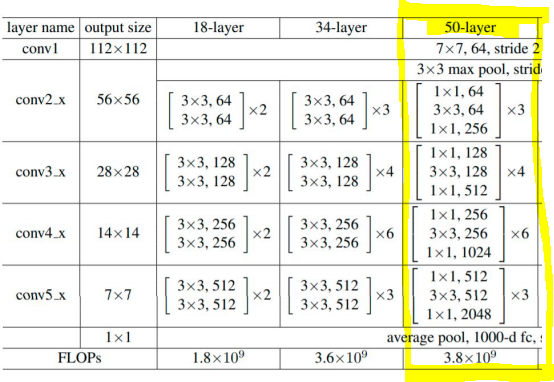

**Bloques Identidad y Convolucion para una red ResNet50**

### - **Bloque Identidad :** 
Este bloque se utiliza cuando se raliza el salto entre capas que contienen las mismas dimensiones. La entrada tiene las mismas dimensiones que la salida

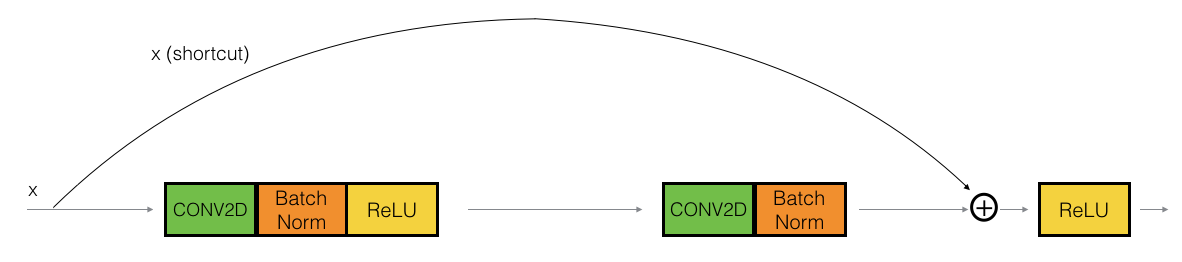

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    El bloque identidad tiene el tamaño del input igual al tamaño del output
    
    # Argumentos
        input_tensor: tensor de entrada
        kernel_size: el default es 3, tamaño del kernel de la capa media en el camino principal
        filters: lista de enteros, cantidad de filtros de las 3 capas CONV en el camino principal
        stage: entrada, rótulo de la etapa actual, usado para generar los nombres de las capas
        block: 'a', 'b'..., rótulo del bloque actual, usado para generar nombres de capas
        
    # Retorna
        Tensor de salida del bloque.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch' # nombre base para las capas convolucionales
    bn_name_base = 'bn' + str(stage) + block + '_branch' # nombre base para las capas residuales

    # sub-bloque a
    # para los nombres utilizar conv_name_base + '2a' para capas conv y bn_name_base + '2a' 
    # agregar una capa Conv2D, usar he_normal como kernel_initializer, kernel_size -> (1,1), # de filtros filters1
    # agregar Batch Normalization
    # agregar activación ReLU
    # esta parte YA fue implementada
    
    x = layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    
    # sub-bloque b
    # para los nombres utilizar conv_name_base + '2b' para capas conv y bn_name_base + '2b' 
    # agregar una capa Conv2D, usar he_normal como kernel_initializer, kernel_size -> el parametro kernel_size
    # # de filtros filters2, padding="same"
    # agregar Batch Normalization
    # agregar activación ReLU
    
    x = layers.Conv2D(filters2, kernel_size=kernel_size,padding="same", kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    # sub-bloque c
    # para los nombres utilizar conv_name_base + '2c' para capas conv y bn_name_base + '2c' 
    # agregar una capa Conv2D, usar he_normal como kernel_initializer, kernel_size -> (1,1), # de filtros filters3
    # agregar Batch Normalization
    # agregar activación ReLU
    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
   
    # shortcut Identidad, realiza la suma directa del tensor de entrada con la capa de salida.
    
    # sumar el tensor de entrada al resultado de las anteriores operaciones (usar la función layers.add(...))
    # agregar activación ReLU
    x = layers.add([x,input_tensor])
    x = layers.Activation('relu')(x)
    # retornar el tensor resultante
    return x

In [ ]:
A_prev = layers.Input([4, 4, 6])
X = np.random.randn(3, 4, 4, 6)
A = identity_block(A_prev, 2, [2, 4, 6],1 ,'a')
model = models.Model(A_prev, A, name='identity_block')
model.summary()

Model: "identity_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 6)]    0                                            
__________________________________________________________________________________________________
res1a_branch2a (Conv2D)         (None, 4, 4, 2)      14          input_1[0][0]                    
__________________________________________________________________________________________________
bn1a_branch2a (BatchNormalizati (None, 4, 4, 2)      8           res1a_branch2a[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 4, 4, 2)      0           bn1a_branch2a[0][0]              
_____________________________________________________________________________________

### - **Bloque Convolucional :** 
Este bloque se utiliza cuando se raliza el salto entre capas no contienen las mismas dimensiones. La dos capas posteriores no tienen las mismas dimensiones que las capas desde donde se realiza la skip conection. Por lo tanto para que coincidan las dimensiones se aplica una capa convolucional en la skip conection y luego se realiza la suma y posterior no linealidad. La no linealidad no se aplica en la skip conection. 

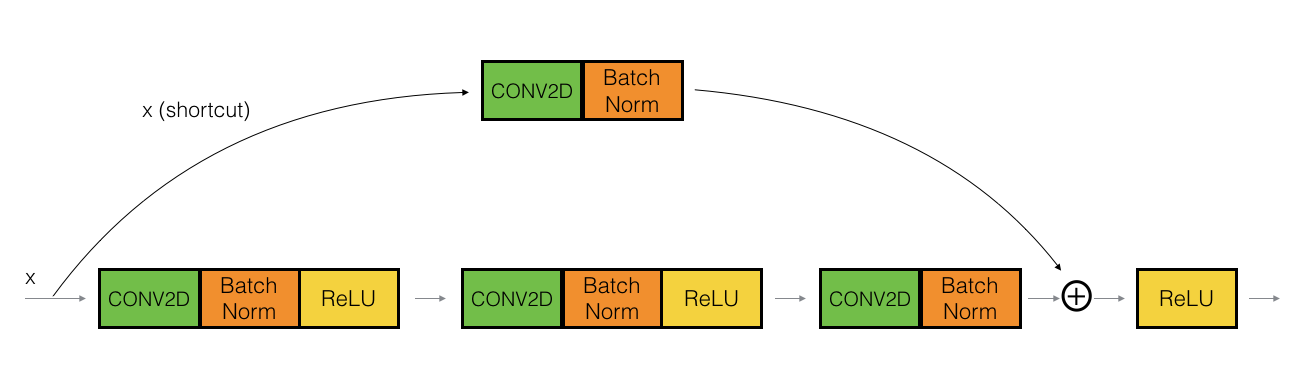

In [ ]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """Un bloque que tiene una capa convolucional como shortcut.

    # Argumentos
        input_tensor: tensor de entrada
        kernel_size: el default es 3, tamaño del kernel de la capa media en el camino principal
        filters: lista de enteros, cantidad de filtros de las 3 capas CONV en el camino principal
        stage: entrada, rótulo de la etapa actual, usado para generar los nombres de las capas
        block: 'a', 'b'..., rótulo del bloque actual, usado para generar nombres de capas
        strides: Strides para la primera capa convolucional del bloque.

    # Retorna
        Tensor de salida del bloque.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # sub-bloque a
    # para los nombres utilizar conv_name_base + '2a' para capas conv y bn_name_base + '2a' 
    # agregar una capa Conv2D, usar he_normal como kernel_initializer, kernel_size -> (1,1)
    # agregar Batch Normalization
    # agregar activación ReLU
    
    x = layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    
    # sub-bloque b
    # para los nombres utilizar conv_name_base + '2b' para capas conv y bn_name_base + '2b' 
    # agregar una capa Conv2D, usar he_normal como kernel_initializer, kernel_size -> el parametro kernel_size
    # # de filtros filters2, padding="same"
    # agregar Batch Normalization
    # agregar activación ReLU

    x = layers.Conv2D(filters2, kernel_size=kernel_size,padding='same',strides=(1,1), 
                            kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    
    # sub-bloque c
    # para los nombres utilizar conv_name_base + '2c' para capas conv y bn_name_base + '2c' 
    # agregar una capa Conv2D, usar he_normal como kernel_initializer, kernel_size -> (1,1), # de filtros filters3
    # agregar Batch Normalization
    # agregar activación ReLU

    x = layers.Conv2D(filters3, (1, 1), strides=(1,1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    x = layers.Activation('relu')(x)
    
    # conexión shortcut:
    # agregar una capa convolucional que actúe sobre el tensor de entrada
    # agregar Batch Normalization
  
    out = layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input_tensor)
    out = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(out)
 
    # aplicar la conexión shortcut al tensor de entrada 
    # y sumarle a esto el resultado de aplicar las anteriores operaciones (el camino principal) 
    # a la entrada
    # agregar activación ReLU
    x = layers.add([x,out])
    x = layers.Activation('relu')(x)
    # retornar el tensor resultante
    return x

In [ ]:
A_prev = layers.Input([4, 4, 6])
X = np.random.randn(3, 4, 4, 6)
A = conv_block(A_prev, 2, [2, 4, 6],1 ,'a')
model = models.Model(A_prev, A, name='conv_block')
model.summary()

Model: "conv_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 4, 4, 6)]    0                                            
__________________________________________________________________________________________________
res1a_branch2a (Conv2D)         (None, 2, 2, 2)      14          input_10[0][0]                   
__________________________________________________________________________________________________
bn1a_branch2a (BatchNormalizati (None, 2, 2, 2)      8           res1a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 2, 2, 2)      0           bn1a_branch2a[0][0]              
_________________________________________________________________________________________

### **ResNet50**

Estamos en condiciones de armar la red con convinaciones de los bloques anteriores

In [ ]:
def ResNet50(input_shape=(224, 224, 3),
             classes=1000,
             **kwargs):
    """
    Instancia la arquitectura ResNet50.
    
    # Argumentos
        input_tensor: tensor de Keras opcional para usar de imagen de entrada al modelo
        optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: tiene que tener 3 canales de entrada
        classes: número opcional de clases en las que clasificar las imágenes

    # Retorna
        Un modelo de Keras
    """

    img_input = layers.Input(shape=input_shape)
    
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='fc1000')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    
    inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='resnet50')

    return model

In [ ]:
model = ResNet50()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________